# imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import random
import datetime
import time

In [3]:
np.random.seed(7654)

# import data

In [5]:
"""
x: weather data (3xN) (april 1st until now)
[[percip1, percip2, percip3, percip4],
 [temp1,   temp2,   ...]
 [bias1,   bias2,   ...]]

y: mbta delays  (1xN) (april 1st until now)
[[delay1,  delay2,  ...]]
includes non-delays.
""";

In [6]:
scaled = pd.read_csv("ruggles2dtxg_weather_scaled.csv")

In [7]:
scaled.columns

Index(['from_time', 'travel_time_sec', '15min', 'time', 'temperature_2m (°C)',
       'precipitation (mm)', 'relative_humidity_2m (%)', 'visibility (m)',
       'wind_speed_10m (km/h)', 'rain (mm)', 'snowfall_height (m)',
       'snowfall (cm)', 'dew_point_2m (°C)', 'lightning_potential (J/kg)',
       'w_code_0', 'w_code_1', 'w_code_2', 'w_code_3', 'w_code_45',
       'w_code_51', 'w_code_53', 'w_code_55', 'w_code_57', 'w_code_61',
       'w_code_63', 'w_code_65', 'w_code_73', 'w_code_75'],
      dtype='object')

In [8]:
scaled[["travel_time_sec",
        'temperature_2m (°C)',
        'precipitation (mm)', 
        'relative_humidity_2m (%)', 
        'visibility (m)',
        'wind_speed_10m (km/h)']]

,travel_time_sec,temperature_2m (°C),precipitation (mm),relative_humidity_2m (%),visibility (m),wind_speed_10m (km/h)
0,437,0.997457,15.318031,1.432484,-1.707322,0.680066
1,454,0.997457,15.318031,1.432484,-1.707322,0.680066
2,628,1.043243,-0.123222,1.666488,-1.106371,0.121651
3,478,1.043243,-0.123222,1.666488,-1.106371,0.121651
4,550,1.027981,-0.123222,1.666488,-1.128629,-0.325081
...,...,...,...,...,...,...
13558,443,0.676961,-0.123222,1.713289,-1.796351,-1.516366
13559,427,0.676961,-0.123222,1.713289,-1.796351,-1.516366
13560,458,0.676961,-0.123222,1.713289,-1.790787,-1.839006
13561,445,0.676961,-0.123222,1.713289,-1.790787,-1.839006


In [9]:
big_five_cols = ['temperature_2m (°C)',
                 'precipitation (mm)',
                 'relative_humidity_2m (%)',
                 'visibility (m)',
                 'wind_speed_10m (km/h)']

In [10]:
# explicitly define x
x = scaled[big_five_cols].copy(deep=True)

# add bias column to x
x["bias"] = np.ones(x.shape[0])

# convert x to numpy
x = x.to_numpy()

In [11]:
# scaler = sklearn.preprocessing.MinMaxScaler()
# y = scaler.fit_transform(scaled["travel_time_sec"].to_numpy().reshape(-1,1))

In [12]:
# explicitly define y
y = scaled["travel_time_sec"].to_numpy()

# pointers
(set pointers for x_train, x_test, y_train, y_test)

In [14]:
def tt_idx(y,train_percent:float):
    y_len = len(y)
    # get random non-repeating 
    # values for unique indicies:
    train_idx = random.sample(range(y_len),
                              int(y_len*train_percent))
    
    # store train vs test in dict
    tt_idx_dict = {
        "train":list(filter(lambda x: 
                            x in train_idx,
                            range(y_len))),
        "test": list(filter(lambda x: 
                            x not in train_idx,
                            range(y_len)))
    }
    
    # return dict
    return tt_idx_dict

In [15]:
tt_idict  = tt_idx(y,0.7)
train_idx = tt_idict["train"]
test_idx  = tt_idict["test"]

In [16]:
x_train = x[train_idx]
y_train = y[train_idx]
x_test  = x[test_idx]
y_test  = y[test_idx]

# define MLP

In [18]:
class AbstractAF:
    """Abstract Activation Function.
    This is an abstract class used to represent
    activation functions in a MultiLayer Perceptitron.

    Each Activation function must have a name
    and implement the following three functions:
    - fw(w,x)         represents a forward pass through the MLP
    - bp_w(w,x)       represents a dL/dw backprop through the MLP
    - bp_x(w,x)       represents a dL/dh backprop through the MLP <- TODO look into this.....

    This class does not implement any of the three functions.
    Child-classes MUST implement all three functions for 
    backprop to work properly.

    In the current implementation, the following classes are the only valid subclasses:
    - LinearAF
    - ReluAF
    """
    def __init__(self):
        self.name = "Abstract"

    def __repr__(self):
        """Overwrites the representation with class name.
        This function makes the print look cleaner :) 
        """
        return f"<ActivationFunction:{self.name}>"
    
    def fw(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

    def bp_w(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

    def bp_x(self,w,x):
        raise NotImplementedError("Abstract Class cannot run functions.  Please use a subclass.")

class MeanSquaredErrorAF(AbstractAF):
    """Mean Squared Error function"""
    def __init__(self):
        super().__init__()
        self.name = "MSE"
        self.axis = 0

    def fw(self,f,y):
        return   np.mean((f-y)**2,axis=1).item()

    def bp(self,f,y):
        # the idea here is that something else
        # needs to take the mean of this AFTER
        # adding all the weights and stuff.
        return 2*(f-y)

class LogLossAF(AbstractAF):
    def __init__(self):
        super().__init__()
        self.name = "LogLoss"
        self.axis = 0
    
    def fw(self,f,y):
        np_epsilon = np.finfo(float).eps
        return np.mean((-y) * np.log(f+np_epsilon) - (1-y) * np.log(1-f+np_epsilon))

    def bp(self,f,y):
        # the idea here is that something else
        # needs to take the mean of this AFTER
        # adding all the weights and stuff.
        return 2*(f-y)

class LinearAF(AbstractAF):
    """Linear Activation Function"""
    def __init__(self):
        super().__init__()
        self.name = "Linear"
    
    def fw(self,w,x):
        return w.T.dot(x)

    def bp(self,a):
        return np.ones(a.shape)

class ReluAF(AbstractAF):
    """Relu Activation Function"""
    def __init__(self):
        super().__init__()
        self.name = "Relu"
        
    def fw(self,w,x):
        return np.maximum(0,w.T.dot(x))

    def bp(self,a):
        return a > 0

class SigmoidAF(AbstractAF):
    """SigmoidAF"""
    def __init__(self):
        super().__init__()
        self.name = "Sigmoid"

    def func(self,a):
        return 1 / (1+np.exp(-a))

    def fw(self,w,x):
        return self.func(w.T.dot(x))

    def bp(self,a):
        return self.func(a) / (1-self.func(a))

In [19]:
class MLP:
    """MultiLayer Perceptron
    Implementation Notes:
    - input and output layers must be defined explicitly.
    """
    def __init__(self,seed=None):
        np.random.seed(seed)
        self.layers  = []
        self.weights = []
        self.loss = MeanSquaredErrorAF()

    def add_layer(self,nodes:int,afunc:AbstractAF) -> None:
        """Adds a layer with a given number of nodes
        and a given Abstract Function"""
        self.layers.append(MLPLayer(nodes,afunc))

    def _init_weights(self) -> None:
        """Initialize weights based on added layers"""
        assert len(self.layers) > 1, "layers must be added"

        # reset weights matrix
        self.weights = []

        # get the shape based on existing layers
        for i in range(1,len(self.layers)):
            w = np.random.rand(self.layers[i-1].get_nodes(),
                       self.layers[i  ].get_nodes())
            self.weights.append(w)

    def fw(self,x:np.array):
        """Performs a forward pass from
        x through n hidden layers to f_w(x)
        by applying an activation function 
        for each layer in the MLP.

        The function also initializes weight
        dimensions, if not done so already.

        Given the input example:
        x_ample = np.ones((3,n))
        
        each column would represent a sample
        ie: 
        > x_ample[:,0]   would be the 1st sample
        > x_ample[:,1]   would be the 2nd sample
        > x_ample[:,n-1] would be the nth sample
        etc.
        
        each row would represent a variable
        ie:
        > x_ample[0,:] would be the 1st parameter
        > x_ample[1,:] would be the 2nd parameter
        > x_ample[2,:] would be the 3rd parameter
        etc.

        The output of this function will generally take the shape:
        (m,n) where n is the number of columns in the input array
        and m is the number of node is the final layer in this MLP.
        In this case, we are predicting one value, how late the
        MBTA will be, and therefore m will always be 1.
        """

        # init weights if not yet done
        if len(self.weights) == 0:
            self._init_weights()

        # initialize x as the hidden value
        # of layer 0 (the input layer)
        self.layers[0].h = x

        # loop through and update x iteratively:
        for i in range(1,len(self.layers)):
            x = self.layers[i].fw(self.weights[i-1],x)

        # return x
        return x

    def get_partial_d_list(self,ridx=0,loss=None):
        """Gets list of factors to
        perform a partial derivate.
        ridx=0 refers to the LAST 
               weight matrix.
        ridx=1 refers to the second
               to last weight matrix
        """
        dlist = []
        current = loss
        dlist.append(current)
        dlist.append(mlp.layers[-1].afunc.bp(current))
    
        if ridx==0:
            # get dh
            current = self.layers[-2].h
            dlist.append(current)
        elif ridx==1:
            # get dw2
            dlist.append(self.weights[-1])
            # add h
            dlist.append(self.layers[-2].h)
            # get x
            dlist.append(self.layers[-3].h)
        elif ridx==2:
            # get dw3
            dlist.append(self.weights[-1])
            # add h2
            dlist.append(self.layers[-2].h)
            # get dw2
            dlist.append(self.weights[-2])
            # add h1
            dlist.append(self.layers[-3].h)
            # get x
            dlist.append(self.layers[-4].h)
        return dlist

    def pair_dlist(self,dlist):
        paired_list = []
        i = 1
        while i < (len(dlist)):
            if dlist[i-1].shape == dlist[i].shape:
                paired_list.append(dlist[i-1]*dlist[i])
                i+=1 
            else:
                paired_list.append(dlist[i])
                i+=1
        return paired_list

    def reconstruct_dlist_no_pairs(self,plist):
        current = plist[0]
        for i in range(1,len(plist)):
            # print(current.shape, plist[i].shape)
            if current.shape == plist[i].shape:
                # print("same shape:")
                current = current*plist[i]
            else:
                try:
                    # get dh
                    current = plist[i].dot(current) 
                    try:
                        # try again 
                        current = plist[i].dot(current.T) 
                    except:
                        pass
                except:
                    # get dw
                    current = current.dot(plist[i].T).T
        return current

    def bp_pipeline(self,ridx,loss):
        dlist = self.get_partial_d_list(ridx,loss)
        plist = self.pair_dlist(dlist)
        dLdw  = self.reconstruct_dlist_no_pairs(plist)
        return dLdw
    
    def gd(self,
           x:np.array,
           y:np.array,
           eta:float=0.1,
           iters:int=10,
           debug:bool=False
          ):
        # start timer
        start = time.time()
        
        # list of errors?
        ls_mse = []
        
        for i in range(iters):
            # compute the fwd pass
            fwp = self.fw(x)
            # compute the loss
            fwl = self.loss.fw(f=fwp,y=y)
            bpl = self.loss.bp(f=fwp,y=y).reshape(1,-1)
            for fidx in range(len(self.weights)):
                ridx = len(self.weights) - fidx - 1
                bpd = self.bp_pipeline(fidx,loss=bpl) # get backprop
                    
                if debug:
                    print(f"shape match: {self.weights[ridx].shape == bpd.shape}")
                    print(f"    self.weights[{ridx}]",self.weights[ridx].shape)
                    print(f"    self._bp_dot[{ridx}]",bpd.shape)

                if bpd.shape == self.weights[ridx].shape:
                    # overwrite the weights if the shapes match:
                    self.weights[ridx] = (self.weights[ridx] - eta * bpd)
                else:
                    # throw error otherwise
                    raise Exception("invalid weight shape"+
                                    f"expected{self.weights[ridx].shape}; got{bpd.shape}")

            # get show the time left:
            now = time.time()
            print(f"progress:{round(100*(i+1)/iters,2)}%\t\ttime_elapsed:{round(now - start,2)}",end="\r")
            ls_mse.append(fwl)
        return ls_mse

In [20]:
class MLPLayer:
    """Represents a single layer in the MLP.
    
    """
    def __init__(self,nodes,afunc):
        self.nodes = int(nodes)
        self.afunc = afunc
        self.h = None

    def __repr__(self):
        """overwrite representation for pretty print"""
        return "<MLPLayer: {nodes:"+f"{self.nodes},afunc:{self.afunc}"+"}>"

    def get_nodes(self):
        return self.nodes+0

    def fw(self,w:np.array,x:np.array):
        """store and return the
        post-activation values 
        of a forward pass."""
        self.h = self.afunc.fw(w=w,x=x)
        return self.h.copy()

# run the program!!

## below is a sanity check using a full-linear model:

In [23]:
# using a full-linear for reference:
mlp = MLP(102)
mlp.add_layer( 6,LinearAF()) # input x
mlp.add_layer(20,LinearAF())
mlp.add_layer(10,LinearAF())
mlp.add_layer( 1,LinearAF()) # prediction f_w(x)

# run 1000 iters of gradient descent
errLin = mlp.gd(x_train.T,
             y_train.T,
             eta=0.000000000005,
             iters=10_000)

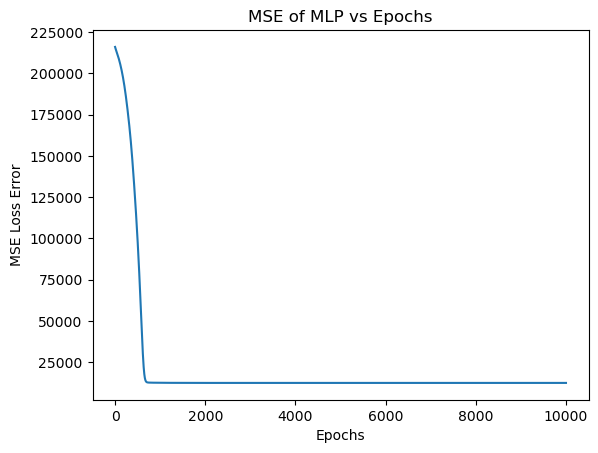

In [24]:
# plot the change in error over iterations
plt.plot(errLin)
plt.title("MSE of MLP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss Error")
plt.show()

In [25]:
print("min_error:",errLin[-1])

min_error: 12535.671614135263


In [26]:
y_pred = mlp.fw(x_test.T).astype(float)
assert np.min(y_pred) >= 0, "relu doesnt work :("
y_pred

array([[481.76544568, 480.39265447, 473.48423549, ..., 470.8827476 ,
        469.24998019, 477.92825712]])

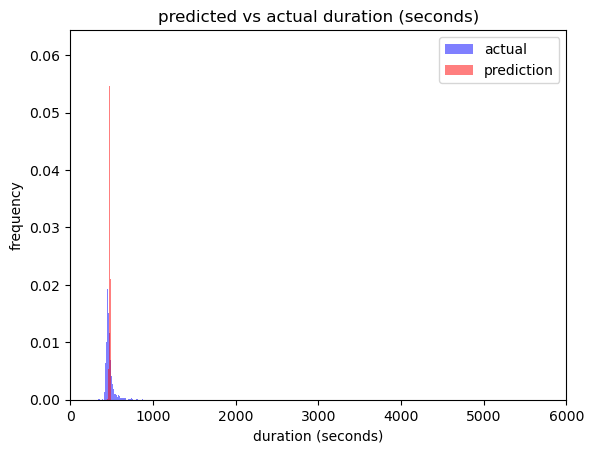

In [27]:
plt.hist(y_test.astype(float).flatten(),bins=200,
         density=True,color="blue",alpha=0.5,
         label = "actual"
        )
plt.hist(y_pred.astype(float).flatten(),bins=20,
         density=True,color="red",alpha = 0.5,
         label = "prediction"
        )

plt.xlim(0,6_000)
plt.title("predicted vs actual duration (seconds)")
plt.xlabel("duration (seconds)")
plt.ylabel("frequency")
plt.legend()
plt.show()

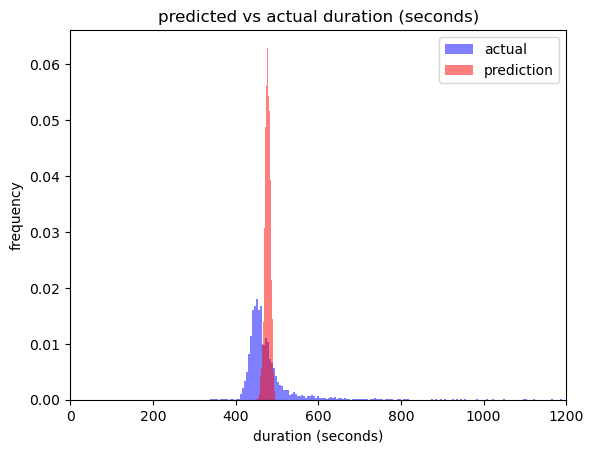

In [28]:
plt.hist(y_test.astype(float).flatten(),bins=300,
         density=True,color="blue",alpha=0.5,
         label = "actual"
        )
plt.hist(y_pred.astype(float).flatten(),bins=29,
         density=True,color="red",alpha = 0.5,
         label = "prediction"
        )

plt.xlim(0,1200)
plt.title("predicted vs actual duration (seconds)")
plt.xlabel("duration (seconds)")
plt.ylabel("frequency")
plt.legend()
plt.show()

# Relu Model

In [30]:
scaler = sklearn.preprocessing.MinMaxScaler()
y = scaled["travel_time_sec"].to_numpy()

In [31]:
# y represents a binary classification 
# about whether it is more than 3 minutes
# late.
y = (y > (np.mean(y) + 60*3)).astype(int)

In [32]:
np.sum(y)

277

In [33]:
tt_idict  = tt_idx(y,0.6)
train_idx = tt_idict["train"]
test_idx  = tt_idict["test"]

In [34]:
x_train = x[train_idx]
y_train = y[train_idx]
x_test  = x[test_idx]
y_test  = y[test_idx]

In [35]:
np.sum(y_test)

119

### running the MLP

In [37]:
rmlp = MLP(102)
rmlp.loss = LogLossAF()
rmlp.add_layer( 6,LinearAF()) # input x
rmlp.add_layer(20,LinearAF())
rmlp.add_layer(10,LinearAF())
rmlp.add_layer( 1,SigmoidAF()) # prediction f_w(x)

# run 1000 iters of gradient descent
errRelu = rmlp.gd(x_train.T,
                  y_train.T,
                  eta=0.00000015,
                  iters=1_000)

In [38]:
# error
errRelu[-1]

0.18568506615317498

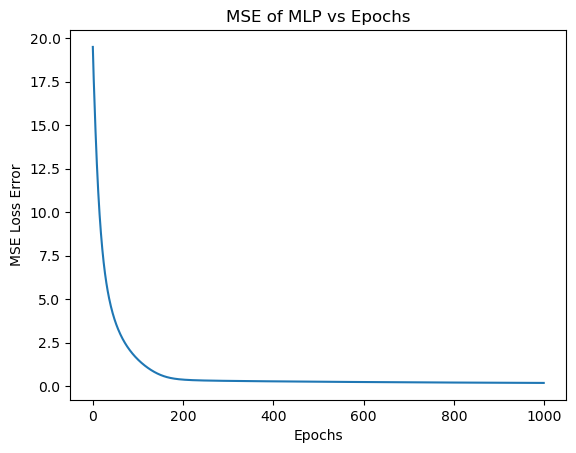

In [39]:
# plot the change in error over iterations
plt.plot(errRelu)
plt.title("MSE of MLP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss Error")
plt.show()

In [40]:
y_pred = rmlp.fw(x_test.T).astype(float)
assert np.min(y_pred) >= 0, "sigmoid doesnt work :("
y_pred

array([[0.0046882 , 0.02474106, 0.03913327, ..., 0.01263135, 0.06735016,
        0.06967113]])

In [41]:
y_test = y_test + np.finfo(float).eps
np.corrcoef(y_pred.flatten(),y_test.flatten())

array([[1.        , 0.01416996],
       [0.01416996, 1.        ]])

## Plot predicted vs actual duration (seconds)

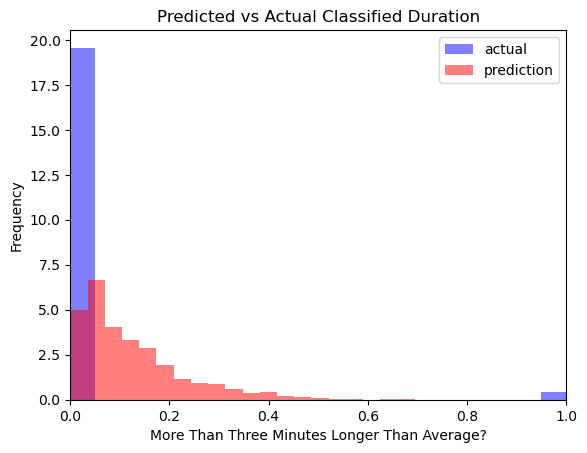

In [43]:
plt.hist(y_test.astype(float).flatten(),bins=20,
         density=True,color="blue",alpha=0.5,
         label = "actual"
        )
plt.hist(y_pred.astype(float).flatten(),bins=20,
         density=True,color="red",alpha = 0.5,
         label = "prediction"
        )

plt.xlim(0,1)
plt.title("Predicted vs Actual Classified Duration")
plt.xlabel("More Than Three Minutes Longer Than Average?")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# summary stats

## Mean:

In [46]:
print("average time (seconds):")
# predicted average time (seconds)
print("  predicted:          ",np.mean(y_pred))
# real average time (seconds)
print("  actual:             ",np.mean(y_test))

average time (seconds):
  predicted:           0.1246494313855651
  actual:              0.021931441208993954


## Var

In [48]:
print("variance of time:")
# predicted average time (seconds)
print("  predicted:          ",np.var(y_pred))
# real average time (seconds)
print("  actual:             ",np.var(y_test))

variance of time:
  predicted:           0.011439695072035063
  actual:              0.02145045309549018


# Covariance

In [50]:
np.corrcoef(y_pred.flatten(),y_test.flatten())

array([[1.        , 0.01416996],
       [0.01416996, 1.        ]])